<a href="https://colab.research.google.com/github/harshitharavi26/PP1/blob/main/InceptionV3_pp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2    
from tqdm import tqdm
import random as random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [7]:
imagedetails = []
imagelabels = []
IMG_SIZE=150
gallina_dir='/content/drive/My Drive/pp_used/gallina'
cane_dir = '/content/drive/My Drive/pp_used/cane'
mucca_dir = '/content/drive/My Drive/pp_used/mucca'
pecora_dir = '/content/drive/My Drive/pp_used/pecora'

In [8]:
def read_image(label,DIR):
    
    for img in tqdm(os.listdir(DIR)):
    #for img in DIR:
        path = os.path.join(DIR,img)
        #checking image type
        _, ftype = os.path.splitext(path)
        if ftype == ".jpeg":
       
            image = cv2.imread(path,cv2.IMREAD_COLOR)
            image = cv2.resize(image, (IMG_SIZE,IMG_SIZE),interpolation = cv2.INTER_AREA)
            imagedetails.append(np.array(image))
            imagelabels.append(str(label))

read_image("gallina",gallina_dir)
read_image("cane",cane_dir)
read_image("mucca",mucca_dir)
read_image("pecora",pecora_dir)

100%|██████████| 990/990 [03:17<00:00,  5.02it/s]


In [9]:
encoder = LabelEncoder()
#converting the images into arrays which will have its intensity values
X = np.array(imagedetails)
print(X)
X = X/255
print(X)
print(imagelabels)
y = encoder.fit_transform(imagelabels)
y = to_categorical(y,4)
print(y)
print(X.shape)
print(y.shape)

[[[[154 191 195]
   [136 177 186]
   [137 187 197]
   ...
   [252 252 252]
   [252 252 252]
   [253 253 253]]

  [[135 170 177]
   [145 183 193]
   [134 180 192]
   ...
   [255 255 255]
   [254 254 254]
   [253 253 253]]

  [[152 184 191]
   [149 182 195]
   [143 181 195]
   ...
   [248 248 248]
   [254 254 254]
   [253 253 253]]

  ...

  [[133 175 198]
   [138 180 203]
   [132 174 197]
   ...
   [223 255 247]
   [247 253 250]
   [255 252 251]]

  [[150 192 215]
   [138 180 203]
   [137 179 202]
   ...
   [241 255 252]
   [252 254 252]
   [255 252 253]]

  [[156 197 220]
   [128 169 192]
   [129 170 193]
   ...
   [249 254 253]
   [251 253 253]
   [254 253 253]]]


 [[[214 157  95]
   [211 154  92]
   [214 157  95]
   ...
   [222 173 127]
   [222 173 129]
   [224 174 132]]

  [[211 154  92]
   [208 151  89]
   [210 154  92]
   ...
   [219 170 124]
   [218 170 126]
   [221 171 129]]

  [[210 153  91]
   [206 149  87]
   [209 152  90]
   ...
   [218 169 123]
   [218 168 124]
   [220 170

In [10]:
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
X_train.shape,y_train.shape,X_valid.shape,y_valid.shape,X_test.shape,y_test.shape

((2328, 150, 150, 3),
 (2328, 4),
 (728, 150, 150, 3),
 (728, 4),
 (582, 150, 150, 3),
 (582, 4))

In [11]:
batch_size = 64
epochs = 100
num_classes = y.shape[1]

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),include_top=False, weights='imagenet')
for layer in pre_trained_model.layers:
  layer.trainable = False
  
from keras import Model
layer_name = 'mixed7'
my_model = Model(inputs=pre_trained_model.input,outputs=pre_trained_model.get_layer(layer_name).output)
my_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [24]:
from keras import models         
model = models.Sequential()
model.add(my_model)
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4,activation='softmax'))
model.layers[7].trainable = False

In [25]:
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [26]:
imagegen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                            rotation_range=60,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              fill_mode='reflect')
imagegen.fit(X_train)

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath = 'cnn3.hdf5',monitor='val_accuracy' ,verbose = 1, save_best_only = True)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,min_lr=0.00001,mode='auto')
model_dropout = model.fit_generator(imagegen.flow(X_train,y_train, batch_size=32),epochs=100,callbacks=[checkpoint,reduce_lr],verbose=2,
                          validation_data=imagegen.flow(X_valid, y_valid,batch_size=32),shuffle=True,steps_per_epoch=X_train.shape[0] // 32)

Epoch 1/100

Epoch 00001: val_accuracy improved from -inf to 0.84753, saving model to cnn3.hdf5
72/72 - 15s - loss: 0.6698 - accuracy: 0.7282 - val_loss: 0.3888 - val_accuracy: 0.8475
Epoch 2/100

Epoch 00002: val_accuracy improved from 0.84753 to 0.87363, saving model to cnn3.hdf5
72/72 - 14s - loss: 0.3616 - accuracy: 0.8650 - val_loss: 0.3642 - val_accuracy: 0.8736
Epoch 3/100

Epoch 00003: val_accuracy did not improve from 0.87363
72/72 - 14s - loss: 0.3090 - accuracy: 0.8811 - val_loss: 0.3587 - val_accuracy: 0.8709
Epoch 4/100

Epoch 00004: val_accuracy did not improve from 0.87363
72/72 - 14s - loss: 0.2833 - accuracy: 0.8998 - val_loss: 0.3760 - val_accuracy: 0.8626
Epoch 5/100

Epoch 00005: val_accuracy did not improve from 0.87363
72/72 - 14s - loss: 0.2499 - accuracy: 0.9077 - val_loss: 0.3840 - val_accuracy: 0.8723
Epoch 6/100

Epoch 00006: val_accuracy improved from 0.87363 to 0.90110, saving model to cnn3.hdf5
72/72 - 14s - loss: 0.1954 - accuracy: 0.9307 - val_loss: 0.32

In [28]:
test_eval = model.evaluate(X_test, y_test, verbose=2)

19/19 - 1s - loss: 0.1979 - accuracy: 0.9433


In [29]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1).astype(int)
y_true = np.argmax(y_test,axis = 1).astype(int)

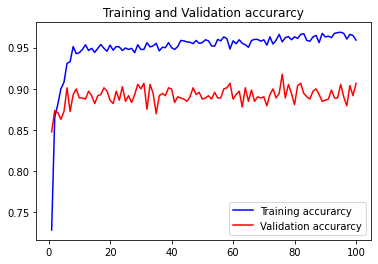

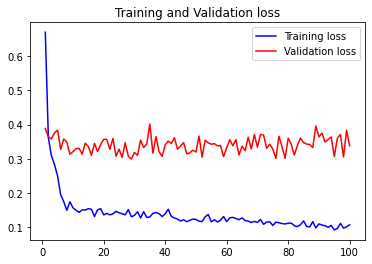

In [30]:
acc = model_dropout.history['accuracy']
val_acc = model_dropout.history['val_accuracy']
loss = model_dropout.history['loss']
val_loss = model_dropout.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [31]:
corr=[]
incorr=[]
corr_count=0
incorr_count=0

for i in range(len(y_test)):
    if(y_pred[i]==y_true[i]):
        corr.append(i)
        corr_count+=1
    else:
        incorr.append(i)
        incorr_count+=1
        
print("Found %d correct" %(corr_count))
print("Found %d incorrect " %(incorr_count))

Found 549 correct
Found 33 incorrect 


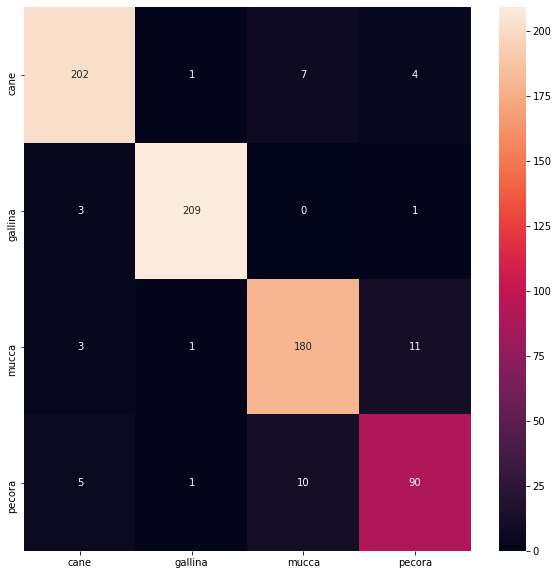

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd 
y_pred=model.predict(X_valid)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_valid,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
#plot the con mat
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(np.unique(imagelabels))
ax.set_yticklabels(np.unique(imagelabels))
plt.show()

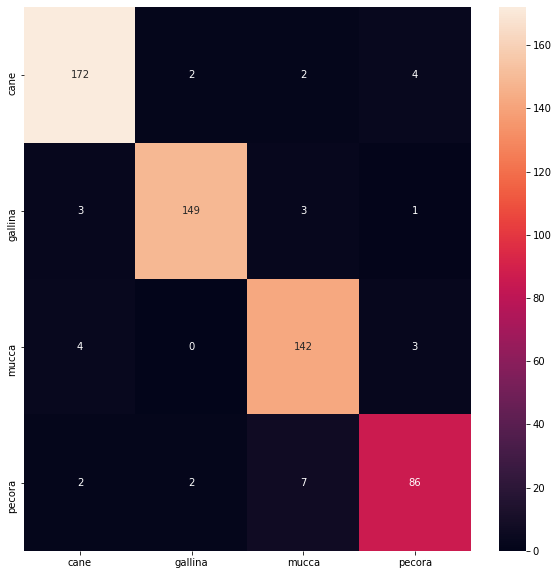

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd 
y_pred=model.predict(X_test)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='.0f')
ax.set_xticklabels(np.unique(imagelabels))
ax.set_yticklabels(np.unique(imagelabels))
plt.show()